<a href="https://colab.research.google.com/github/OELSHARK/Loan_Default_Classification/blob/main/Loan_Default_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries & Load Data

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
df = pd.read_csv('Loan_default.csv')
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [ ]:
import pandas as pd
import numpy as np

def info_data(df: pd.DataFrame, *, target=None, id_col=None):
    line = "-"*70
    def section(title):
        print(f"{title} ".center(70, "-"))

    # Shape & memory
    section("SHAPE & MEMORY")
    print(f"Rows: {df.shape[0]}")
    print(f"Cols: {df.shape[1]}")
    mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
    print(f"Memory: {mem_mb:.2f} MB")

    # Types
    section("DTYPES")
    print(df.dtypes)

    # Missing values
    section("MISSING VALUES")
    miss = df.isna().sum()
    if miss.sum() == 0:
        print("No missing values ")
    else:
        miss_df = (
            pd.DataFrame({"missing": miss, "pct": (miss/len(df))*100})
            .query("missing > 0")
            .sort_values("missing", ascending=False)
        )
        print(miss_df.to_string(float_format=lambda x: f"{x:.2f}%"))

    # Duplicates & constant columns
    section("DUPLICATES & CONSTANTS")
    dup_rows = df.duplicated().sum()
    print(f"Duplicate rows: {dup_rows}")
    if id_col and id_col in df.columns:
        dup_ids = df[id_col].duplicated().sum()
        print(f"Duplicate {id_col}: {dup_ids}")
    const_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
    print(f"Constant columns: {const_cols if const_cols else 'None'}")

    # Quick numeric summary
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        section("NUMERIC SUMMARY (describe)")
        print(df[num_cols].describe().T)

    # Quick categorical summary
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if cat_cols:
        section("CATEGORICAL SUMMARY (nunique & top values)")
        nunique = df[cat_cols].nunique().sort_values(ascending=False)
        print("Unique counts:")
        print(nunique.to_string())
        print("\nTop categories per column (first 5):")
        for c in cat_cols:
            vc = df[c].value_counts(dropna=False).head(5)
            print(f"\n{c}:")
            print(vc.to_string())

    # Target distribution (optional)
    if target and target in df.columns:
        section(f"TARGET DISTRIBUTION: {target}")
        counts = df[target].value_counts().sort_index()
        pct = (counts / len(df) * 100).round(2)
        dist = pd.DataFrame({"count": counts, "pct": pct})
        print(dist.to_string())

# usage


In [ ]:
info_data(df, target="Default", id_col="LoanID")


---------------------------SHAPE & MEMORY ----------------------------
Rows: 255347
Cols: 18
Memory: 142.40 MB
-------------------------------DTYPES --------------------------------
LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object
---------------------------MISSING VALUES ----------------------------
No missing values ✅
-----------------------DUPLICATES & CONSTANTS ------------------------
Duplicate rows: 0
Duplicate LoanID: 0
Constant columns: None
---------------------NUMERIC SUMMARY (describe) ----------------------
                   count           mean   

In [ ]:
#NO missing Data & No Duplicates


#EDA & Pre processing



In [ ]:
import matplotlib.pyplot as plt

def column_distribution(df, column, normalize=False):
    """
    Show the distribution of a specific column as counts and a bar plot.

    Parameters:
    df : pandas DataFrame
    column : str - the column name
    normalize : bool - if True, shows percentages instead of raw counts
    """
    counts = df[column].value_counts(normalize=normalize)
    print(f"Distribution for '{column}':\n")
    print(counts)

    plt.figure(figsize=(8,4))
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Percentage" if normalize else "Count")
    plt.xticks(rotation=45)
    plt.show()



Distribution for 'Education':

Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64


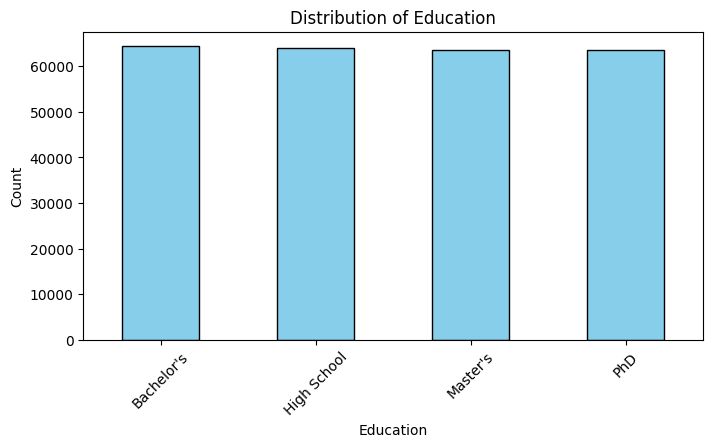

In [ ]:
column_distribution(df, "Education")

Distribution for 'Default':

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64


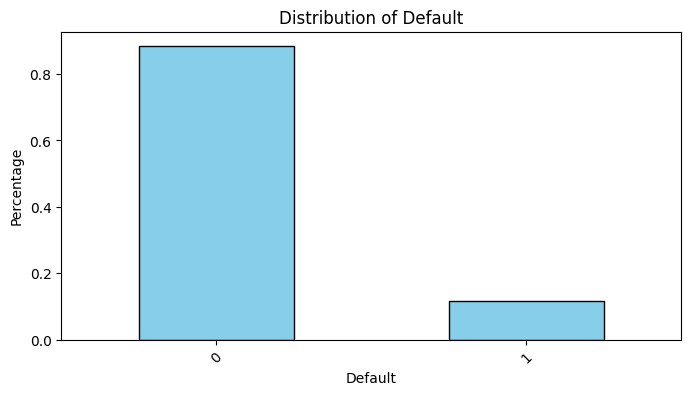

In [ ]:
column_distribution(df, "Default", True)     # Percentages


In [ ]:
import pandas as pd

education_mapping = {
    "High School": 0,
    "Bachelor's": 1,
    "Master's": 2,
    "PhD": 3
}

df["Education"] = df["Education"].map(education_mapping)

print(df["Education"].head(10))


0    1
1    2
2    2
3    0
4    1
5    0
6    1
7    3
8    1
9    0
Name: Education, dtype: int64


Distribution for 'EmploymentType':

EmploymentType
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: count, dtype: int64


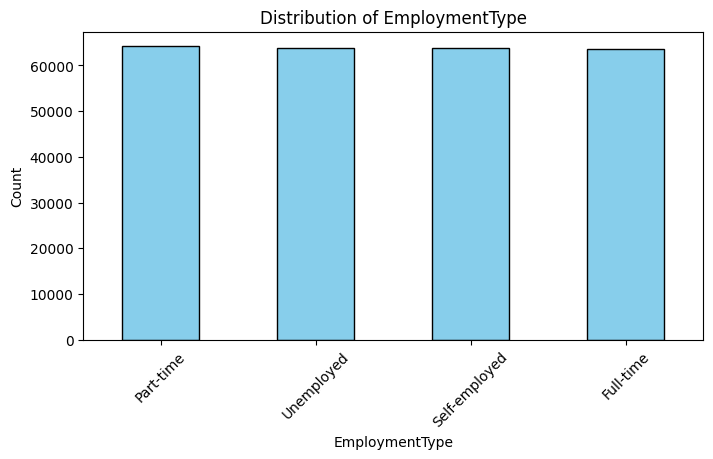

In [ ]:
column_distribution(df, "EmploymentType")

In [ ]:
EmploymentType_mapping ={
    'Full-time':0,
    'Part-time':1,
    'Self-employed':2,
    'Unemployed':3
}

df["EmploymentType"] = df["EmploymentType"].map(EmploymentType_mapping)
print(df["EmploymentType"].head(10))

0    0
1    0
2    3
3    0
4    3
5    3
6    3
7    0
8    2
9    2
Name: EmploymentType, dtype: int64


In [ ]:
def encode_column(df, column, order=None):
    """
    Encode a categorical column into numeric values.

    Parameters:
    df : pandas DataFrame
    column : str - column name
    order : list - custom order of categories (optional)

    If no order is provided, categories will be encoded in sorted order.
    """
    if order:
        mapping = {cat: idx for idx, cat in enumerate(order)}
    else:
        unique_values = sorted(df[column].unique())
        mapping = {cat: idx for idx, cat in enumerate(unique_values)}

    df[column] = df[column].map(mapping)
    return mapping




In [ ]:
MaritalStatus_mapping =encode_column(df, "MaritalStatus")
print(MaritalStatus_mapping)

{'Divorced': 0, 'Married': 1, 'Single': 2}


In [ ]:
df["HasMortgage"] = df["HasMortgage"].map({"No": 0, "Yes": 1})


In [ ]:
df['HasDependents'] = df['HasDependents'].map({'No': 0, 'Yes': 1})

In [ ]:
LoanPurpose_mapping = encode_column(df, "LoanPurpose")
print(LoanPurpose_mapping)

{'Auto': 0, 'Business': 1, 'Education': 2, 'Home': 3, 'Other': 4}


In [ ]:
df['HasCoSigner'] = df['HasCoSigner'].map({'No' : 0, 'Yes' : 1})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  int64  
 11  EmploymentType  255347 non-null  int64  
 12  MaritalStatus   255347 non-null  int64  
 13  HasMortgage     255347 non-null  int64  
 14  HasDependents   255347 non-null  int64  
 15  LoanPurpose     255347 non-null  int64  
 16  HasCoSigner     255347 non-null  int64  
 17  Default   

In [ ]:
float_cols = df.select_dtypes(include=['float64']).columns
for col in float_cols:
    df[col] = df[col].astype(int)

In [ ]:
df = df.drop('LoanID', axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   Age             255347 non-null  int64
 1   Income          255347 non-null  int64
 2   LoanAmount      255347 non-null  int64
 3   CreditScore     255347 non-null  int64
 4   MonthsEmployed  255347 non-null  int64
 5   NumCreditLines  255347 non-null  int64
 6   InterestRate    255347 non-null  int64
 7   LoanTerm        255347 non-null  int64
 8   DTIRatio        255347 non-null  int64
 9   Education       255347 non-null  int64
 10  EmploymentType  255347 non-null  int64
 11  MaritalStatus   255347 non-null  int64
 12  HasMortgage     255347 non-null  int64
 13  HasDependents   255347 non-null  int64
 14  LoanPurpose     255347 non-null  int64
 15  HasCoSigner     255347 non-null  int64
 16  Default         255347 non-null  int64
dtypes: int64(17)
memory usage: 33.1 MB


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_column(df, column):
    """
    Draw a boxplot for a specific numeric column to visualize outliers.

    Parameters:
    df : pandas DataFrame
    column : str - the column name
    """
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column], color='skyblue')
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)
    plt.show()

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")
    print(f"Number of outliers in '{column}': {outliers.shape[0]}")
    return outliers




--- Age ---


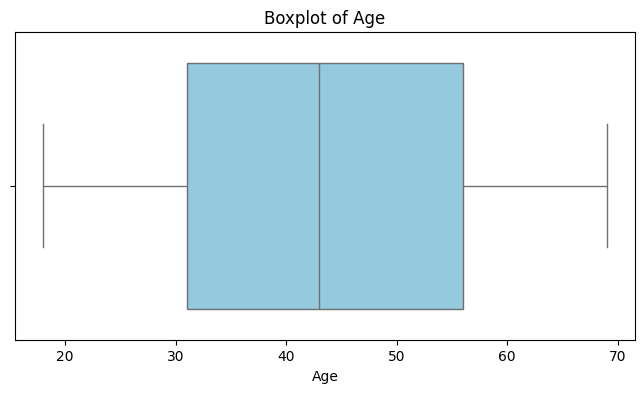

Lower bound: -6.5
Upper bound: 93.5
Number of outliers in 'Age': 0
--- Income ---


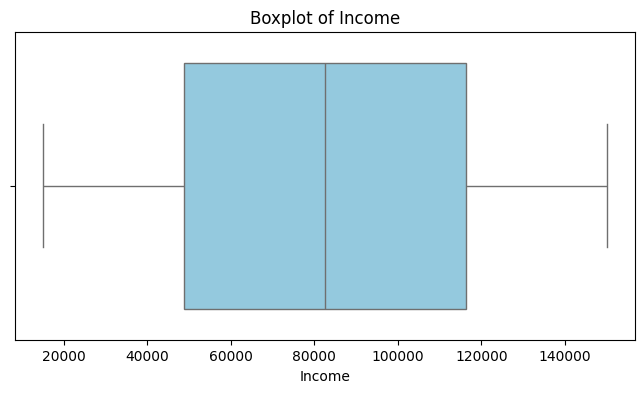

Lower bound: -52264.75
Upper bound: 217309.25
Number of outliers in 'Income': 0
--- LoanAmount ---


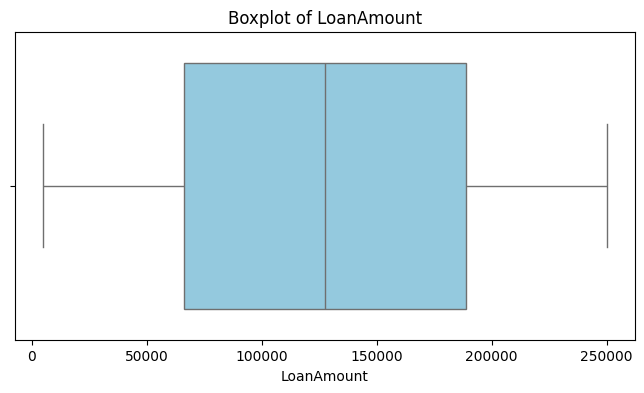

Lower bound: -118087.5
Upper bound: 373228.5
Number of outliers in 'LoanAmount': 0
--- CreditScore ---


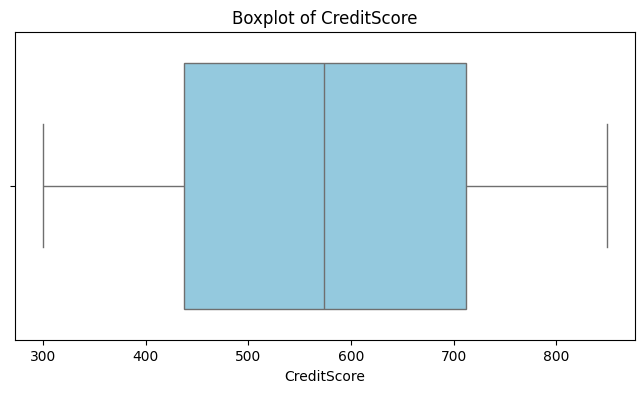

Lower bound: 24.5
Upper bound: 1124.5
Number of outliers in 'CreditScore': 0
--- MonthsEmployed ---


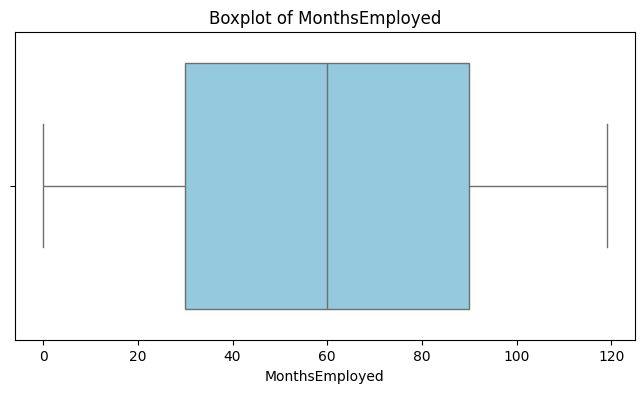

Lower bound: -60.0
Upper bound: 180.0
Number of outliers in 'MonthsEmployed': 0
--- NumCreditLines ---


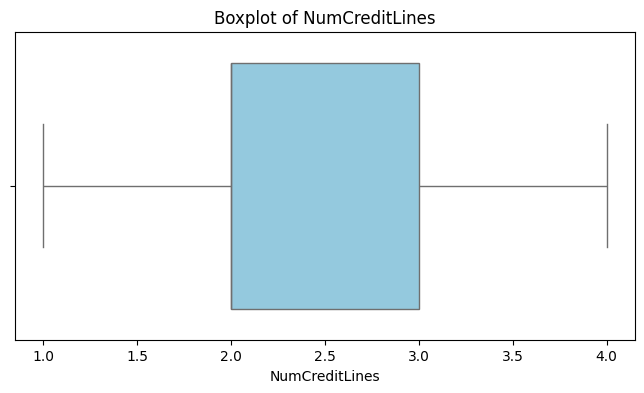

Lower bound: 0.5
Upper bound: 4.5
Number of outliers in 'NumCreditLines': 0
--- InterestRate ---


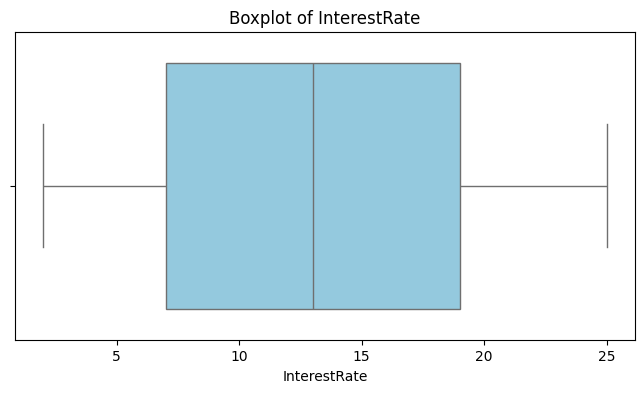

Lower bound: -11.0
Upper bound: 37.0
Number of outliers in 'InterestRate': 0
--- LoanTerm ---


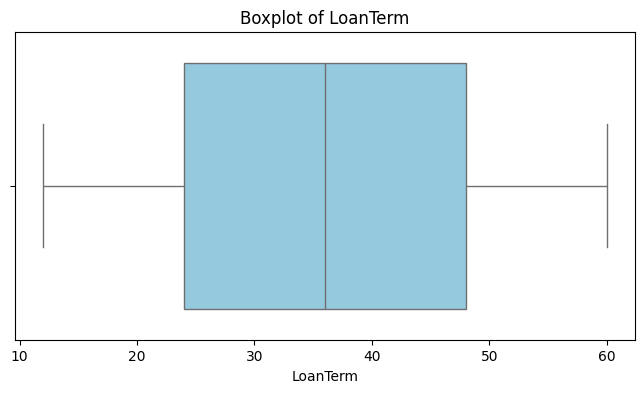

Lower bound: -12.0
Upper bound: 84.0
Number of outliers in 'LoanTerm': 0
--- DTIRatio ---


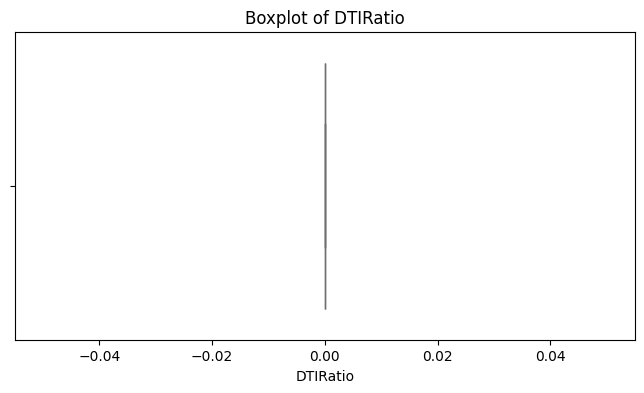

Lower bound: 0.0
Upper bound: 0.0
Number of outliers in 'DTIRatio': 0
--- Education ---


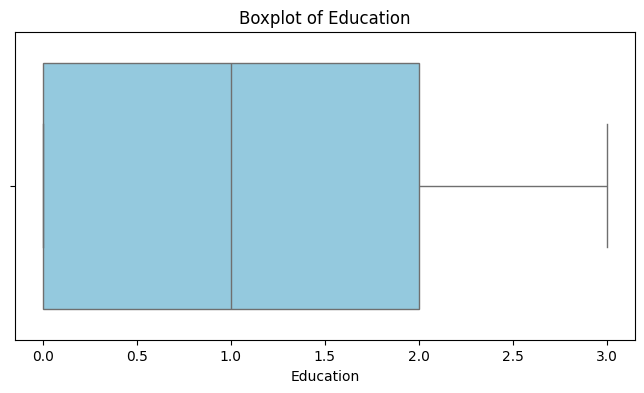

Lower bound: -3.0
Upper bound: 5.0
Number of outliers in 'Education': 0
--- EmploymentType ---


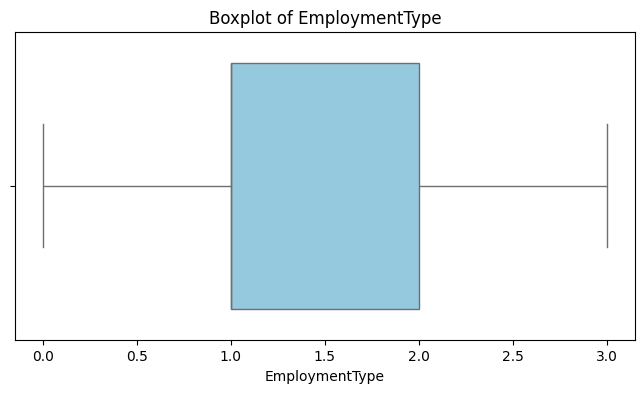

Lower bound: -0.5
Upper bound: 3.5
Number of outliers in 'EmploymentType': 0
--- MaritalStatus ---


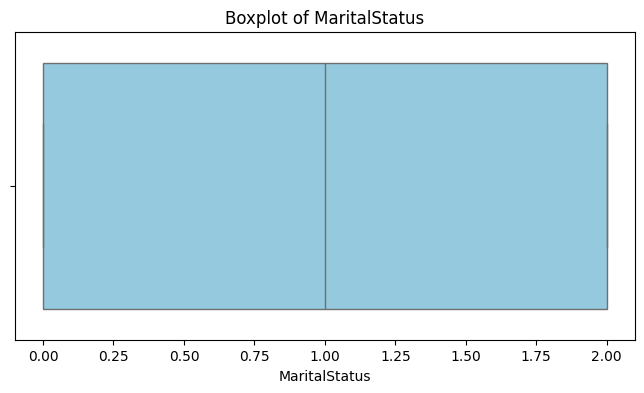

Lower bound: -3.0
Upper bound: 5.0
Number of outliers in 'MaritalStatus': 0
--- HasMortgage ---


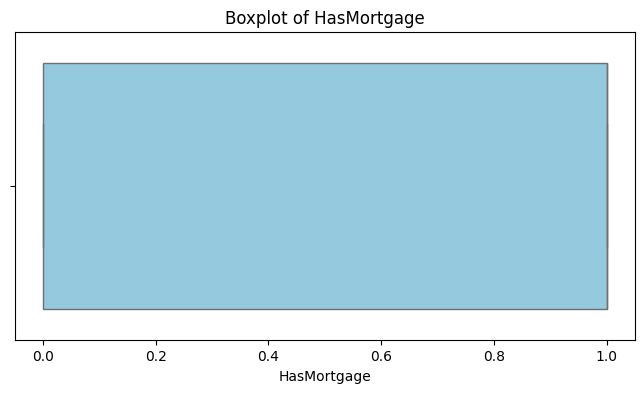

Lower bound: -1.5
Upper bound: 2.5
Number of outliers in 'HasMortgage': 0
--- HasDependents ---


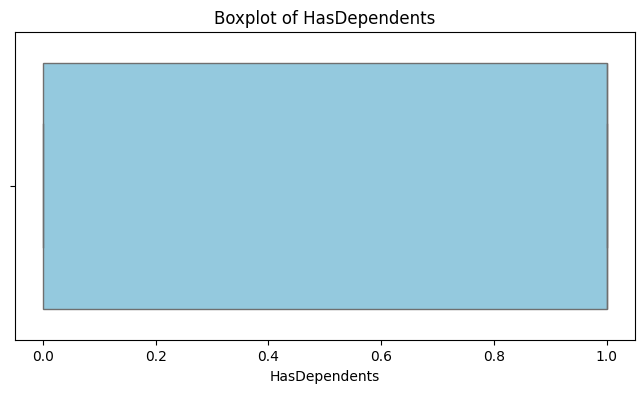

Lower bound: -1.5
Upper bound: 2.5
Number of outliers in 'HasDependents': 0
--- LoanPurpose ---


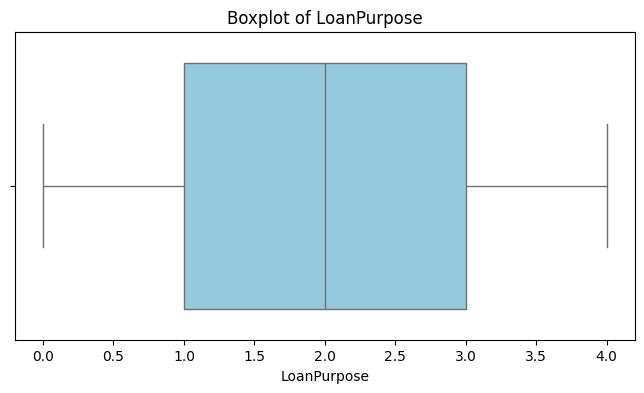

Lower bound: -2.0
Upper bound: 6.0
Number of outliers in 'LoanPurpose': 0
--- HasCoSigner ---


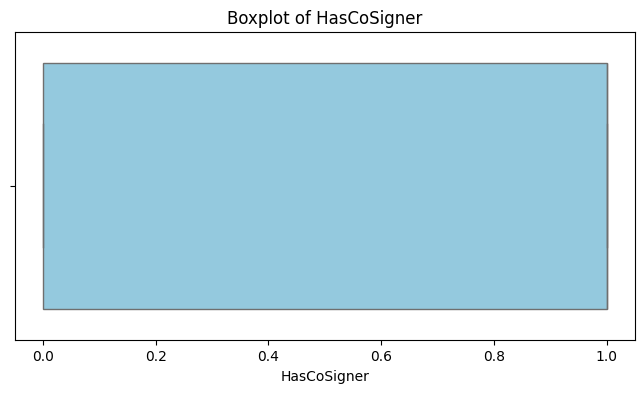

Lower bound: -1.5
Upper bound: 2.5
Number of outliers in 'HasCoSigner': 0
--- Default ---


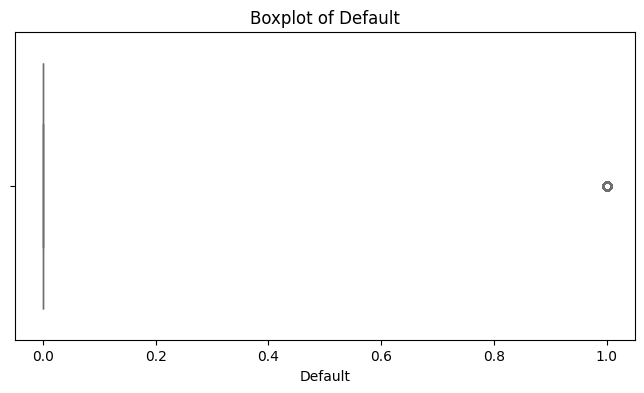

Lower bound: 0.0
Upper bound: 0.0
Number of outliers in 'Default': 29653


In [ ]:
# numeric columns only
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

#  draw boxplots
for col in num_cols:
    print(f"--- {col} ---")
    boxplot_column(df, col)


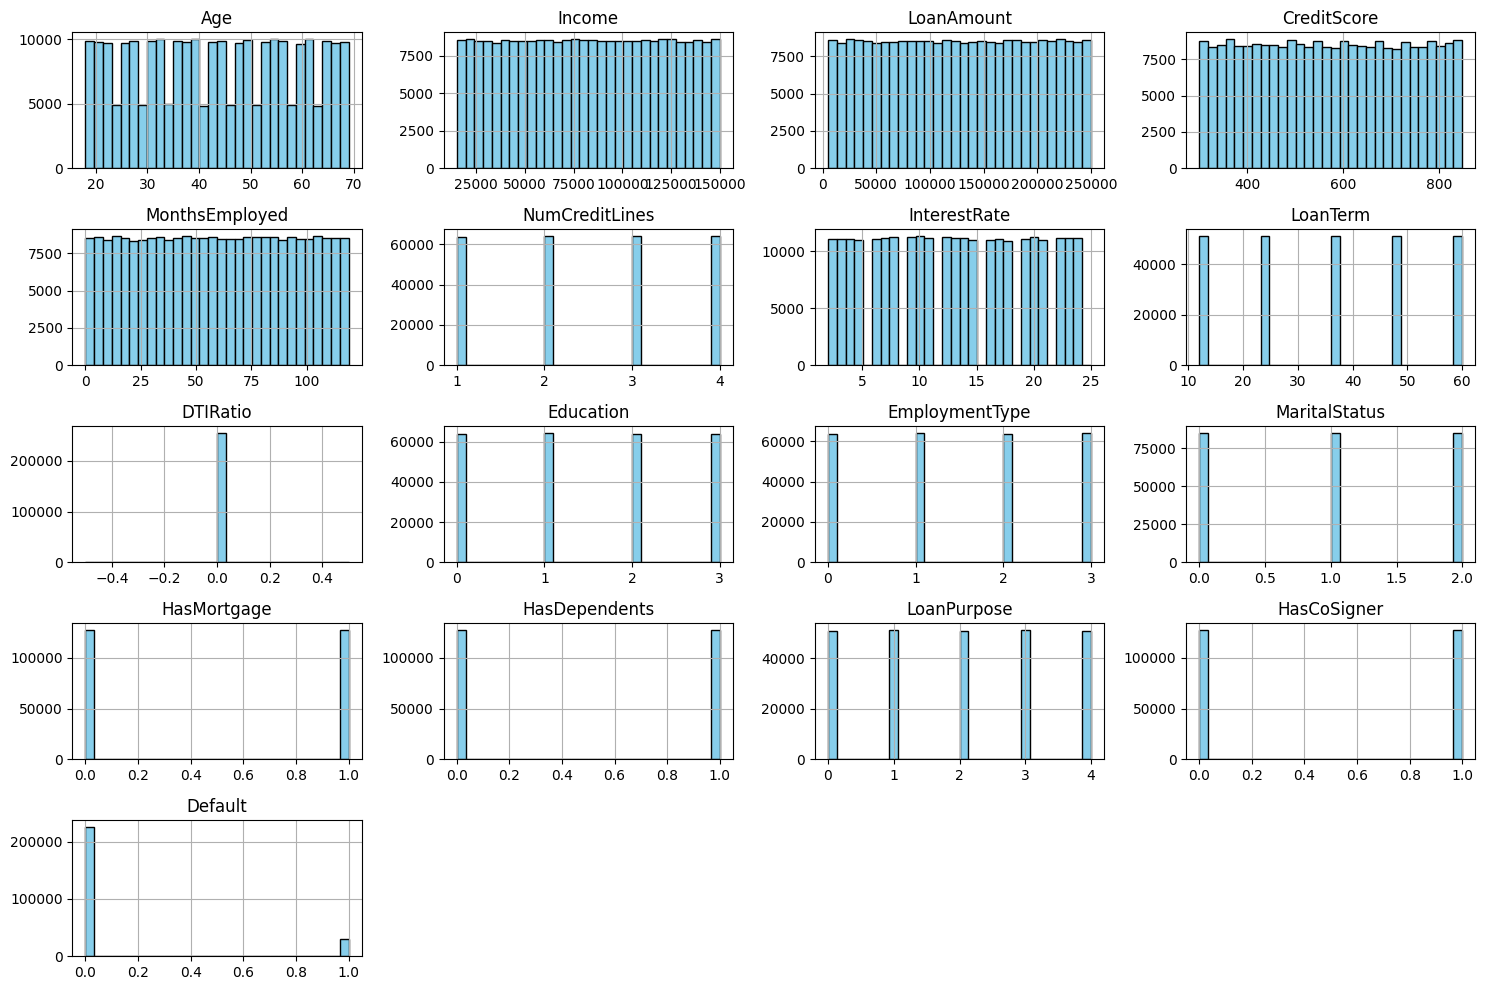

In [ ]:
import matplotlib.pyplot as plt

def hist_all_numeric(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[num_cols].hist(figsize=(15, 10), bins=30, color='skyblue', edgecolor='black')
    plt.tight_layout()
    plt.show()

hist_all_numeric(df)


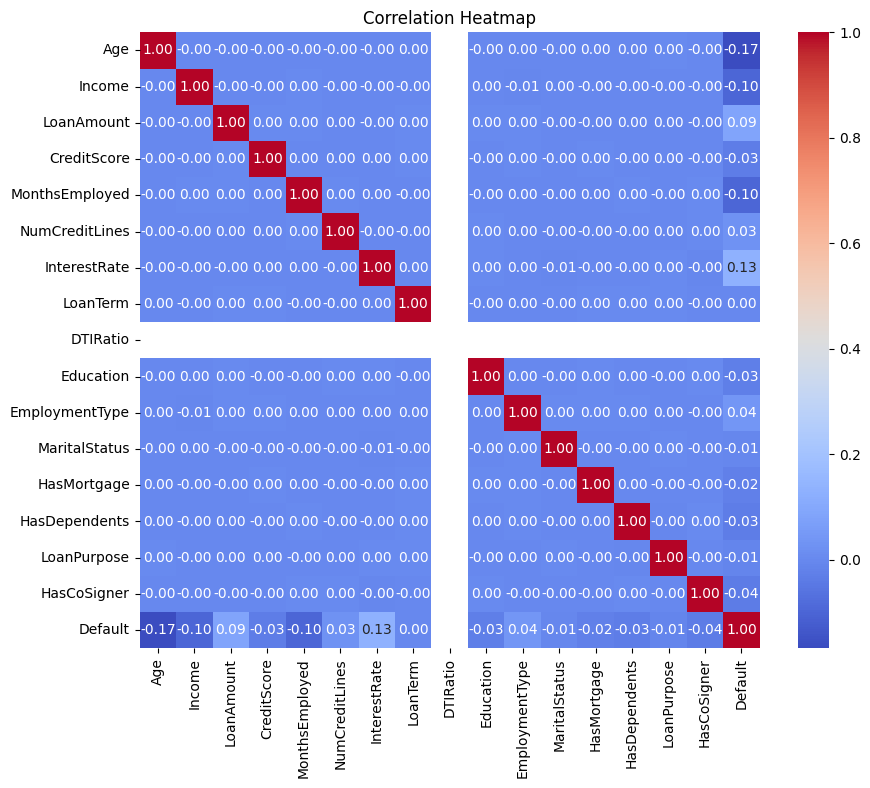

In [ ]:
def correlation_heatmap(df):
    num_cols = df.select_dtypes(include=['int64']).columns
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

correlation_heatmap(df)


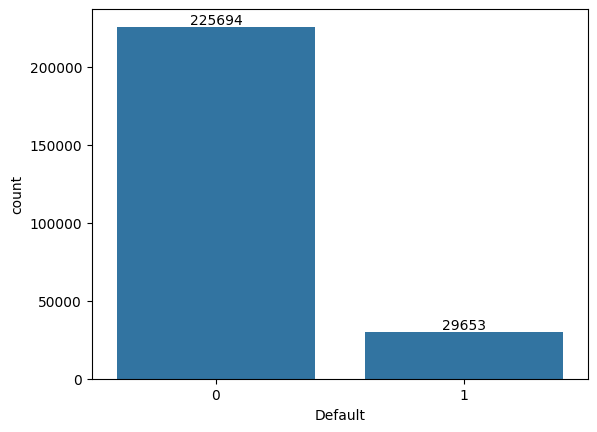

In [ ]:
ax=sns.countplot(df,x='Default')
for container in ax.containers:
    ax.bar_label(container)

#split data

In [ ]:
from sklearn.model_selection import train_test_split
x=df.drop('Default',axis=1)
y=df['Default']

#handel Imbalnce

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

In [ ]:
from collections import Counter
print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 225694, 1: 225694})


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=0.95)
x_train_pca=pca.fit_transform(x_train)
x_test_pca=pca.transform(x_test)

In [ ]:
!pip install xgboost
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [ ]:
x_train_sample, _, y_train_sample, _ = train_test_split(x_train_pca, y_train, test_size=0.85, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid_rf = {
    'max_depth': [ 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}
rf = RandomForestClassifier(n_estimators=200,random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=1, verbose=2)
grid_rf.fit(x_train_sample, y_train_sample)

print("Best params:", grid_rf.best_params_)
print("CV accuracy:", grid_rf.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  25.4s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  23.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  23.9s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  24.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=  23.4s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=  23.2s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=  23.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=  

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200,random_state=42,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',criterion='entropy',max_depth=20)
rf_model.fit(x_train_pca, y_train)
y_pred = rf_model.predict(x_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8194909058685395


In [ ]:
print("classification_report: \n",classification_report(y_test, y_pred))


classification_report: 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82     45127
           1       0.82      0.82      0.82     45151

    accuracy                           0.82     90278
   macro avg       0.82      0.82      0.82     90278
weighted avg       0.82      0.82      0.82     90278



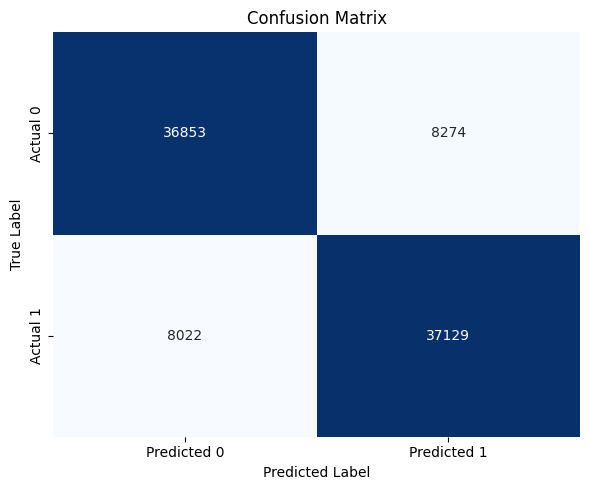

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# great output with handel imbalande problem with SMOTE but its NOT REAL

#so here we use Down Sampling solution on mjority calss to be the ratio 3:1 to minoritry class

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)
#temp combination for chosse the right amount from majorty class
train_df = pd.concat([X_train, y_train.rename('Default')], axis=1)

#defind which one maj and min
counts = train_df['Default'].value_counts()
majority_label = counts.idxmax()  # 0
minority_label = counts.idxmin()  # 1

majority = train_df[train_df['Default'] == majority_label]
minority = train_df[train_df['Default'] == minority_label]
#lets take only 50% of majorty class and kepp the other class the same
majority_half = majority.sample(frac=0.5, random_state=42)

train_ds = pd.concat([majority_half, minority], axis=0)\
             .sample(frac=1, random_state=42).reset_index(drop=True)

X_train_ds = train_ds.drop('Default', axis=1)
y_train_ds = train_ds['Default']

print('قبل:', counts.to_dict())
print('بعد :', y_train_ds.value_counts().to_dict())


قبل: {0: 180555, 1: 23722}
بعد : {0: 90278, 1: 23722}


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

np.random.seed(42)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

print("Train dist :", Counter(y_train))
print("Test  dist :", Counter(y_test))


Train dist : Counter({0: 180555, 1: 23722})
Test  dist : Counter({0: 45139, 1: 5931})


In [ ]:
train_df = pd.concat([X_train, y_train.rename('Default')], axis=1)

counts = train_df['Default'].value_counts()
majority_label = counts.idxmax()
minority_label = counts.idxmin()

majority = train_df[train_df['Default'] == majority_label]
minority = train_df[train_df['Default'] == minority_label]

# Calculate the desired number of samples in the majority class
desired_majority_count = 3 * len(minority)

# Downsample the majority class
majority_downsampled = majority.sample(n=desired_majority_count, random_state=42)

# Combine the downsampled majority class with the minority class
train_ds = pd.concat([majority_downsampled, minority], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_ds = train_ds.drop('Default', axis=1)
y_train_ds = train_ds['Default']

print("Original train data distribution:", counts.to_dict())
print("Downsampled train data distribution:", Counter(y_train_ds))

Original train data distribution: {0: 180555, 1: 23722}
Downsampled train data distribution: Counter({0: 71166, 1: 23722})


In [ ]:
train_df = pd.concat([X_train, y_train.rename('Default')], axis=1)

counts = train_df['Default'].value_counts()
majority_label = counts.idxmax()
minority_label = counts.idxmin()

majority = train_df[train_df['Default'] == majority_label]
minority = train_df[train_df['Default'] == minority_label]

# Sample the majority class to be twice the size of the minority class
desired_majority_count = 2 * len(minority)
majority_downsampled = majority.sample(n=desired_majority_count, random_state=42)

train_ds = pd.concat([majority_downsampled, minority], axis=0)\
             .sample(frac=1, random_state=42).reset_index(drop=True)

X_train_ds = train_ds.drop('Default', axis=1)
y_train_ds = train_ds['Default']

print("Original train data distribution:", counts.to_dict())
print("Downsampled train data distribution:", Counter(y_train_ds))

Original train data distribution: {0: 180555, 1: 23722}
Downsampled train data distribution: Counter({0: 47444, 1: 23722})


#randomForest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1

)

rf.fit(X_train_ds, y_train_ds)

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    max_depth=10,           # Limit tree depth
    min_samples_split=10,    # Minimum samples required to split a node
    min_samples_leaf=5, # Minimum samples required at a leaf node
    max_features='sqrt',     # Limit the number of features considered for splitting
    max_samples=0.8,         # Limit the fraction of samples used for fitting
    class_weight='balanced'  # Handle class imbalance
)

rf.fit(X_train_ds, y_train_ds)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_samples=0.8,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=400, n_jobs=-1, random_state=42)

In [ ]:
proba = rf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC :", roc_auc_score(y_test, proba))
print("PR-AUC  :", average_precision_score(y_test, proba))
print(classification_report(y_test, pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

ROC-AUC : 0.7543082503965934
PR-AUC  : 0.3225448848955129
              precision    recall  f1-score   support

           0     0.9419    0.7157    0.8134     45139
           1     0.2348    0.6638    0.3469      5931

    accuracy                         0.7097     51070
   macro avg     0.5883    0.6898    0.5801     51070
weighted avg     0.8597    0.7097    0.7592     51070

Confusion matrix:
 [[32307 12832]
 [ 1994  3937]]
0.7096925788133934


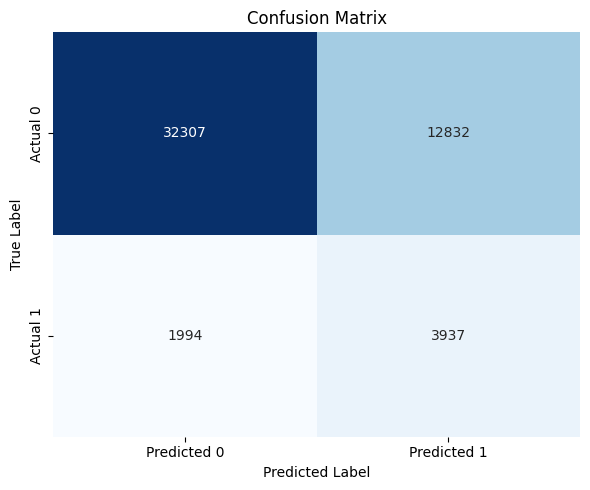

In [ ]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#LifgtGBM

In [ ]:
!pip install lightgbm
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500,  # Increase the number of boosting rounds
    learning_rate=0.05, # Reduce learning rate for better convergence
    max_depth=10,       # Limit tree depth
    num_leaves=31,      # Control the number of leaves (default is 31)
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' # Handle class imbalance
)
lgbm.fit(X_train_ds, y_train_ds)

[LightGBM] [Info] Number of positive: 23722, number of negative: 47444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 71166, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=10,
               n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
proba = lgbm.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC :", roc_auc_score(y_test, proba))
print("PR-AUC  :", average_precision_score(y_test, proba))
print(classification_report(y_test, pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

ROC-AUC : 0.7564258406083662
PR-AUC  : 0.32616046774873353
              precision    recall  f1-score   support

           0     0.9433    0.6968    0.8015     45139
           1     0.2279    0.6810    0.3415      5931

    accuracy                         0.6949     51070
   macro avg     0.5856    0.6889    0.5715     51070
weighted avg     0.8602    0.6949    0.7481     51070

Confusion matrix:
 [[31452 13687]
 [ 1892  4039]]
0.6949481104366556


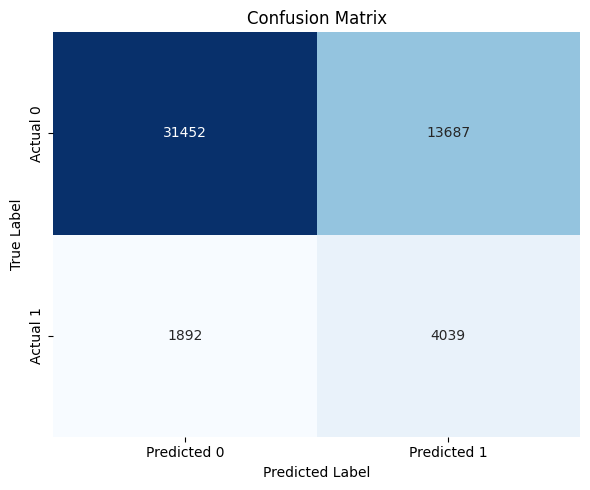

In [ ]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    n_estimators=500,             # Number of boosting rounds
    learning_rate=0.05,           # Step size shrinkage used in update to prevent overfitting
    max_depth=7,                  # Maximum depth of a tree
    subsample=0.8,                # Subsample ratio of the training instances
    colsample_bytree=0.8,         # Subsample ratio of columns when constructing each tree
    random_state=42,
    n_jobs=-1,                    # Use all available cores
    scale_pos_weight=len(y_train_ds[y_train_ds==0])/len(y_train_ds[y_train_ds==1]) # Handle imbalance
)

xgb.fit(X_train_ds, y_train_ds)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
proba = xgb.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC :", roc_auc_score(y_test, proba))
print("PR-AUC  :", average_precision_score(y_test, proba))
print(classification_report(y_test, pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

ROC-AUC : 0.7502693986598484
PR-AUC  : 0.31732710373932316
              precision    recall  f1-score   support

           0     0.9395    0.7184    0.8142     45139
           1     0.2322    0.6481    0.3419      5931

    accuracy                         0.7103     51070
   macro avg     0.5859    0.6833    0.5781     51070
weighted avg     0.8574    0.7103    0.7594     51070

Confusion matrix:
 [[32429 12710]
 [ 2087  3844]]
0.7102604268650872


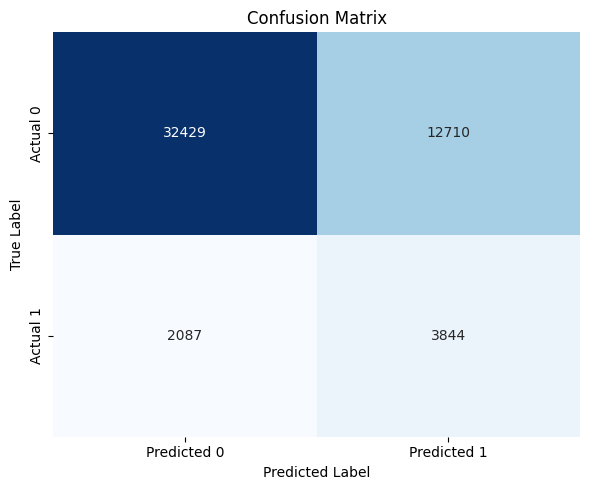

In [ ]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#save the best model

In [ ]:
import pickle

# Save the model
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

print("XGBoost model saved successfully to 'xgboost_model.pkl' using pickle")

XGBoost model saved successfully to 'xgboost_model.pkl' using pickle


In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1

)

rf.fit(X_train_ds, y_train_ds)


RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

In [ ]:
proba = rf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC :", roc_auc_score(y_test, proba))
print("PR-AUC  :", average_precision_score(y_test, proba))
print(classification_report(y_test, pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


ROC-AUC : 0.7474443662767835
PR-AUC  : 0.3151492491433629
              precision    recall  f1-score   support

           0     0.8991    0.9735    0.9348     45139
           1     0.4551    0.1683    0.2457      5931

    accuracy                         0.8800     51070
   macro avg     0.6771    0.5709    0.5903     51070
weighted avg     0.8475    0.8800    0.8548     51070

Confusion matrix:
 [[43944  1195]
 [ 4933   998]]


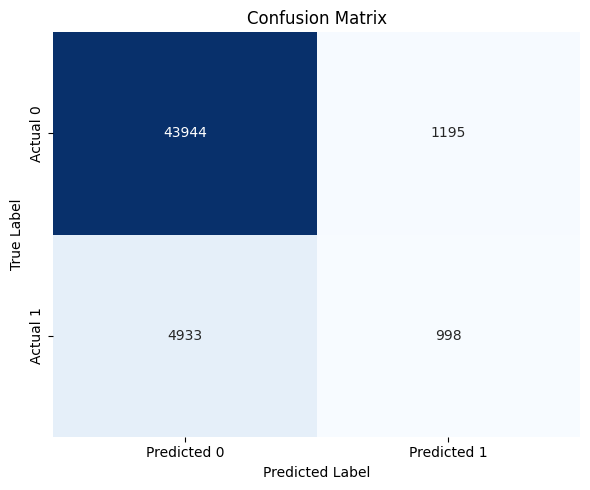

In [ ]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()